In [20]:
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sklearn.metrics
import seaborn as sns

# 1. 데이터 로드
file_path = '/Users/pyojihun/Desktop/쿠다/toy_modeling/final_dataset 1(수정).csv'

def read_csv_with_encodings(file_path):
    """여러 인코딩으로 CSV 파일을 읽는 함수"""
    encodings = ['utf-8', 'cp949', 'euc-kr']
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"✅ '{file_path}' 파일을 '{encoding}' 인코딩으로 성공적으로 불러왔습니다.")
            return df
        except (UnicodeDecodeError, FileNotFoundError):
            continue
    raise UnicodeDecodeError(f"파일을 읽을 수 없습니다. 지원되지 않는 인코딩 방식입니다: {file_path}")

try:
    df = read_csv_with_encodings(file_path)
except (FileNotFoundError, UnicodeDecodeError) as e:
    print(f"오류: {e}. 데이터 파일을 찾을 수 없거나 인코딩 오류입니다. 경로 및 인코딩을 확인하세요.")
    sys.exit()

# 2. 특성 공학 (Feature Engineering)
# 타겟 변수 생성
df['is_cancelled'] = df['status'].apply(lambda x: 1 if x == '취소' else 0)

# 목적지 인코딩을 위한 매핑 딕셔너리
kor_to_eng = {
    '김포': 'GMP', '부산': 'PUS', '광주': 'KWJ', '청주': 'CJJ', '대구': 'TAE',
    '울산': 'USN', '여수': 'RSU', '포항경주': 'KPO', '함양': 'HMY', '양양': 'YNY',
    '군산': 'KUV', '나리타': 'NRT', '간사이': 'KIX', '오키나와': 'OKA', '기타큐슈': 'KKJ', '후쿠오카': 'FUK',
    '베이징다싱': 'PKX', '베이징': 'PEK', '상하이푸동': 'PVG', '상하이홍차오': 'SHA', '항저우': 'HGH',
    '닝보': 'NGB', '선양': 'SHE', '창춘': 'CGQ', '칭다오': 'TAO', '톈진': 'TSN',
    '푸저우': 'FOC', '광저우': 'CAN', '충칭': 'CKG', '시안': 'XIY', '선전': 'SZX',
    '샤먼': 'XMN', '타이베이': 'TPE', '가오슝': 'KHH', '타이중': 'RMQ', '홍콩': 'HKG',
    '마카오': 'MFM', '싱가포르': 'SIN', '하노이': 'HAN', '자카르타': 'CGK', '울란바토르': 'ULN',
    '원주': 'WJU', '김해': 'PUS', '푸동': 'PVG', '사천': 'HIN', '타이완 타오위안 국제 공항': 'TPE',
    '심양': 'SHE', '베이징 다싱 국제공항': 'PKX', '무안': 'MWX', '도쿄/나리타': 'NRT',
    '남경': 'NKG', '푸저우(복주)': 'FOC', '수안나폼(방콕)': 'BKK', '선전(심천)': 'SZX',
    '인천': 'ICN', '정저우': 'CGO', '청도': 'TAO', '다낭': 'DAD', '노이바이(하노이)': 'HAN',
    '천진': 'TSN', '상해/홍차우': 'SHA', '수난 슈오팡 국제공항': 'WUX', '위린 위양 공항': 'UYN',
    '오르도스 에진 호로 국제 공항': 'DSN', '장춘': 'CGQ'
}

destination_mapping = {
    'GMP': 0, 'PUS': 1, 'KWJ': 2, 'CJJ': 3, 'TAE': 4, 'USN': 5, 'RSU': 6, 'KPO': 7, 
    'HMY': 8, 'YNY': 9, 'KUV': 10, 'NRT': 11, 'KIX': 12, 'OKA': 13, 'KKJ': 14, 'FUK': 15,
    'PKX': 16, 'PEK': 17, 'PVG': 18, 'SHA': 19, 'HGH': 20, 'NGB': 21, 'SHE': 22, 'CGQ': 23, 
    'TAO': 24, 'TSN': 25, 'FOC': 26, 'CAN': 27, 'CKG': 28, 'XIY': 29, 'SZX': 30, 'XMN': 31, 
    'TPE': 32, 'KHH': 33, 'RMQ': 34, 'HKG': 35, 'MFM': 36, 'SIN': 37, 'HAN': 38, 'CGK': 39, 
    'ULN': 40, 'WJU': 41, 'HIN': 42, 'MWX': 43, 'NKG': 44, 'BKK': 45, 'ICN': 46, 'CGO': 47, 
    'DAD': 48, 'WUX': 49, 'UYN': 50, 'DSN': 51
}

# 목적지 인코딩 적용
df['destination_eng'] = df['destination'].map(kor_to_eng)
df['destination_encoded'] = df['destination_eng'].map(destination_mapping)

# 시간 변수 처리
df['STD_dt'] = pd.to_datetime(df['STD'], errors='coerce')
df['STD_hour'] = df['STD_dt'].dt.hour
df['STD_minute'] = df['STD_dt'].dt.hour * 60 + df['STD_dt'].dt.minute

# 3. 모델 학습을 위한 데이터 준비
features = [
    'is_weekend', 'is_peak', 'month', 'day', '해면기압(hPa)', 'destination_encoded',
    'STD_hour', 'STD_minute', '기온(°C)', '10분평균풍속(KT)', '10분평균풍향(deg)',
    '10분평균MOR(m)', '누적강수량(mm)', '기온-이슬점 온도', '풍속*sin(풍향-활주로)',
    '운행 위험 지수', '이슬점차리스크', '날씨 강도 지수', '계절_봄', '계절_여름',
    '계절_가을', '계절_겨울', '항공시간대_새벽', '항공시간대_오전', '항공시간대_오후',
    '항공시간대_저녁', '항공시간대_밤'
]

# 결측치 확인
print("--- 각 특성별 결측치 개수 ---")
print(df[features].isna().sum())

X = df[features]
y = df['is_cancelled']

# 데이터 분할 (학습용/테스트용)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 데이터 분할 (학습용/검증용)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("\n데이터 분할 완료!")
print(f"학습용 데이터셋 크기: {len(X_train)}")
print(f"검증용 데이터셋 크기: {len(X_val)}")
print(f"테스트용 데이터셋 크기: {len(X_test)}")


✅ '/Users/pyojihun/Desktop/쿠다/toy_modeling/final_dataset 1(수정).csv' 파일을 'cp949' 인코딩으로 성공적으로 불러왔습니다.
--- 각 특성별 결측치 개수 ---
is_weekend                0
is_peak                   0
month                     0
day                       0
해면기압(hPa)                 0
destination_encoded       2
STD_hour                  0
STD_minute                0
기온(°C)                   86
10분평균풍속(KT)               0
10분평균풍향(deg)              0
10분평균MOR(m)               0
누적강수량(mm)              1930
기온-이슬점 온도                 0
풍속*sin(풍향-활주로)            0
운행 위험 지수                  0
이슬점차리스크                   0
날씨 강도 지수                  0
계절_봄                      0
계절_여름                     0
계절_가을                     0
계절_겨울                     0
항공시간대_새벽                  0
항공시간대_오전                  0
항공시간대_오후                  0
항공시간대_저녁                  0
항공시간대_밤                   0
dtype: int64

데이터 분할 완료!
학습용 데이터셋 크기: 6419
검증용 데이터셋 크기: 1605
테스트용 데이터셋 크기: 2006


/var/folders/kr/fh4d_kgd6_9f59z7nqfdzzk00000gn/T/ipykernel_9260/3278205769.py:69: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['STD_dt'] = pd.to_datetime(df['STD'], errors='coerce')


In [26]:

# 4. 모델 학습
model = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=42, early_stopping_rounds=10)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# 5. 모델 평가
# 시각화를 위한 폰트 설정 (macOS)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 예측 확률 계산
predicted_probabilities = model.predict_proba(X_test)
P_cancel = predicted_probabilities[:, 1]

# 임계값 기반 예측
threshold = 0.50
y_pred = (P_cancel >= threshold).astype(int)


[0]	validation_0-logloss:0.46323
[1]	validation_0-logloss:0.44003
[2]	validation_0-logloss:0.42053
[3]	validation_0-logloss:0.40279
[4]	validation_0-logloss:0.38703
[5]	validation_0-logloss:0.37159
[6]	validation_0-logloss:0.35827
[7]	validation_0-logloss:0.34578
[8]	validation_0-logloss:0.33444
[9]	validation_0-logloss:0.32417
[10]	validation_0-logloss:0.31462
[11]	validation_0-logloss:0.30584
[12]	validation_0-logloss:0.29755
[13]	validation_0-logloss:0.28982
[14]	validation_0-logloss:0.28264
[15]	validation_0-logloss:0.27615
[16]	validation_0-logloss:0.26964
[17]	validation_0-logloss:0.26364
[18]	validation_0-logloss:0.25804
[19]	validation_0-logloss:0.25290
[20]	validation_0-logloss:0.24813
[21]	validation_0-logloss:0.24380
[22]	validation_0-logloss:0.23906
[23]	validation_0-logloss:0.23480
[24]	validation_0-logloss:0.23125
[25]	validation_0-logloss:0.22754
[26]	validation_0-logloss:0.22444
[27]	validation_0-logloss:0.22134
[28]	validation_0-logloss:0.21834
[29]	validation_0-loglos


모델 정확도: 0.9462

--- 모델 성능 리포트 ---
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1611
           1       0.88      0.84      0.86       395

    accuracy                           0.95      2006
   macro avg       0.92      0.91      0.91      2006
weighted avg       0.95      0.95      0.95      2006


--- 정오 행렬 (Confusion Matrix) ---
[[1565   46]
 [  62  333]]


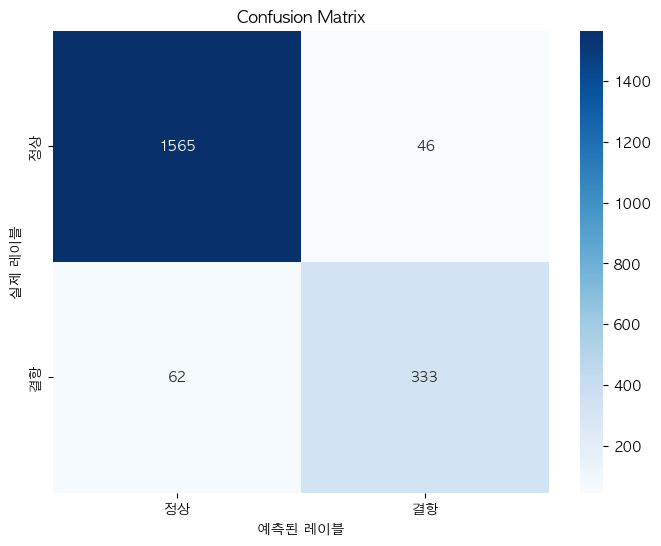


--- ROC-AUC 평가 ---
AUC (Area Under Curve): 0.9816


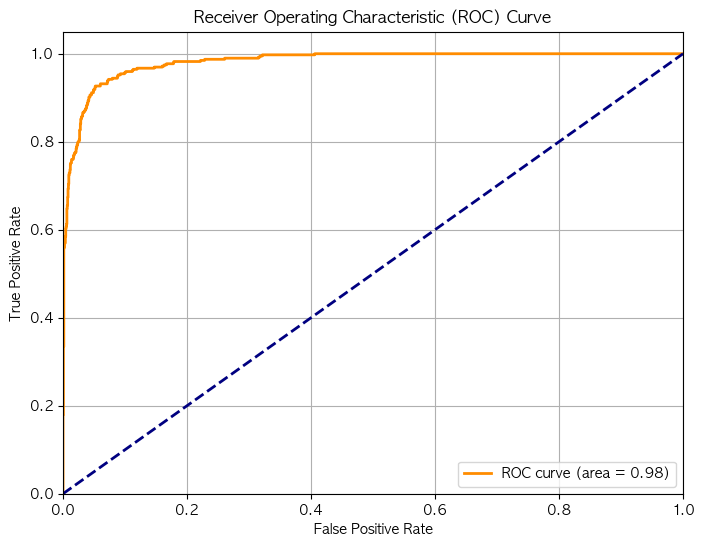

In [27]:

# 정확도
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print(f"\n모델 정확도: {accuracy:.4f}")


# 성능 리포트
print("\n--- 모델 성능 리포트 ---")
print(sklearn.metrics.classification_report(y_test, y_pred))

# 정오 행렬 (Confusion Matrix)
print("\n--- 정오 행렬 (Confusion Matrix) ---")
conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

# 정오 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['정상', '결항'], yticklabels=['정상', '결항'])
plt.xlabel('예측된 레이블')
plt.ylabel('실제 레이블')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC 평가
print("\n--- ROC-AUC 평가 ---")
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, P_cancel)
roc_auc = sklearn.metrics.auc(fpr, tpr)
print(f"AUC (Area Under Curve): {roc_auc:.4f}")

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


/opt/anaconda3/envs/khuda/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:18:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "iterations", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost(조기종료 x) 모델 정확도: 0.9108

--- XGBoost(조기종료 x) 모델 성능 리포트 ---
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1611
           1       0.91      0.61      0.73       395

    accuracy                           0.91      2006
   macro avg       0.91      0.80      0.84      2006
weighted avg       0.91      0.91      0.90      2006


--- XGBoost(조기종료 x) 모델 정오 행렬 (Confusion Matrix) ---
[[1588   23]
 [ 156  239]]


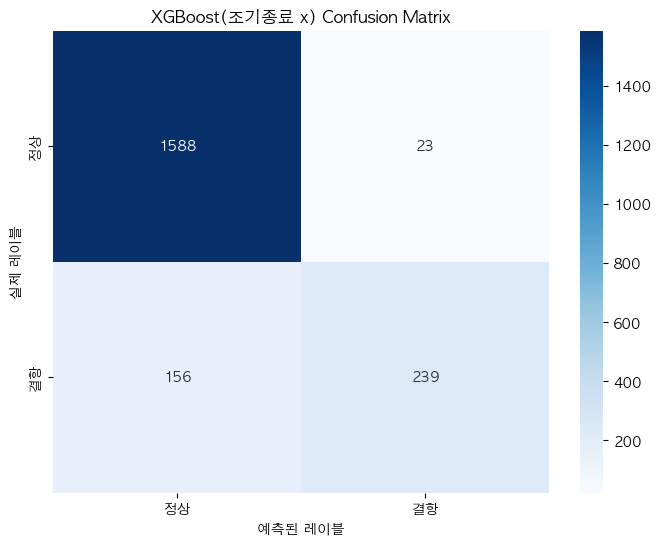


--- XGBoost(조기종료 x) ROC-AUC 평가 ---
XGBoost(조기종료 x) AUC (Area Under Curve): 0.9591


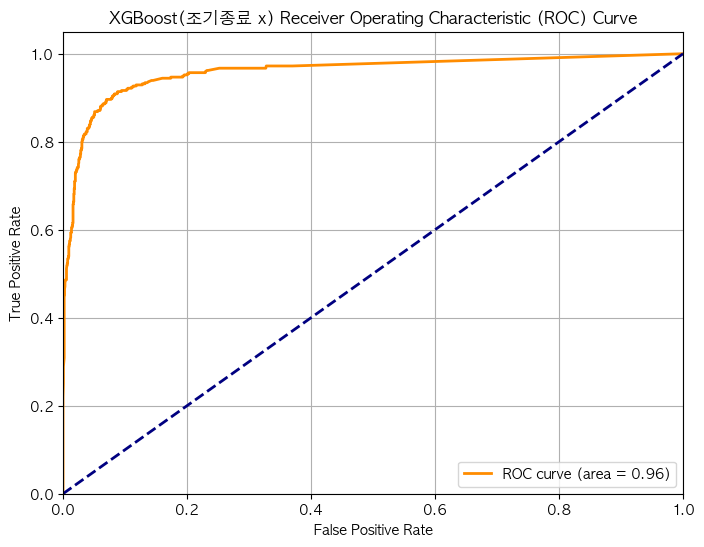

In [25]:
model2 = XGBClassifier(iterations=500, learning_rate=0.01, random_state=42, verbose=0)
model2.fit(X_train, y_train)

#예측 확률 계산
predicted_probabilities2 = model2.predict_proba(X_test)
P_cancel2 = predicted_probabilities2[:, 1]

# 임계값 기반 예측
threshold = 0.50
y_pred2 = (P_cancel2 >= threshold).astype(int) 

# 정확도
accuracy2 = sklearn.metrics.accuracy_score(y_test, y_pred2)
print(f"\nXGBoost(조기종료 x) 모델 정확도: {accuracy2:.4f}")       
# 성능 리포트
print("\n--- XGBoost(조기종료 x) 모델 성능 리포트 ---")
print(sklearn.metrics.classification_report(y_test, y_pred2))
# 정오 행렬 (Confusion Matrix)
print("\n--- XGBoost(조기종료 x) 모델 정오 행렬 (Confusion Matrix) ---")
conf_matrix2 = sklearn.metrics.confusion_matrix(y_test, y_pred2)
print(conf_matrix2)

#정오 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['정상', '결항'], yticklabels=['정상', '결항'])
plt.xlabel('예측된 레이블')
plt.ylabel('실제 레이블')
plt.title('XGBoost(조기종료 x) Confusion Matrix')
plt.show()  

# ROC-AUC 평가
print("\n--- XGBoost(조기종료 x) ROC-AUC 평가 ---")
fpr2, tpr2, thresholds2 = sklearn.metrics.roc_curve(y_test, P_cancel2)
roc_auc2 = sklearn.metrics.auc(fpr2, tpr2)
print(f"XGBoost(조기종료 x) AUC (Area Under Curve): {roc_auc2:.4f}")      

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost(조기종료 x) Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()  